In [1]:
%matplotlib inline

# This nb is modified from DGL documentation
- https://docs.dgl.ai/en/0.8.x/tutorials/blitz/1_introduction.html 
- https://docs.dgl.ai/en/0.8.x/tutorials/blitz/3_message_passing.html \
With some additional material...


How Does DGL Represent A Graph?
===============================

By the end of this tutorial you will be able to:

-  Construct a graph in DGL from scratch.
-  Assign node and edge features to a graph.
-  Query properties of a DGL graph such as node degrees and
   connectivity.
-  Transform a DGL graph into another graph.
-  Load and save DGL graphs.

(Time estimate: 16 minutes)


DGL Graph Construction
----------------------

DGL represents a directed graph as a ``DGLGraph`` object. You can
construct a graph by specifying the number of nodes in the graph as well
as the list of source and destination nodes.  Nodes in the graph have
consecutive IDs starting from 0.

For instance, the following code constructs a directed star graph with 5
leaves. The center node's ID is 0. The edges go from the
center node to the leaves.




In [85]:
import dgl
import numpy as np
import torch

g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]), num_nodes=6)
# Equivalently, PyTorch LongTensors also work.
g = dgl.graph((torch.LongTensor([0, 0, 0, 0, 0]), torch.LongTensor([1, 2, 3, 4, 5])), num_nodes=6)

# You can omit the number of nodes argument if you can tell the number of nodes from the edge list alone.
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]))

Edges in the graph have consecutive IDs starting from 0, and are
in the same order as the list of source and destination nodes during
creation.




In [86]:
# Print the source and destination nodes of every edge.
print(g.edges())

(tensor([0, 0, 0, 0, 0]), tensor([1, 2, 3, 4, 5]))


<div class="alert alert-info"><h4>Note</h4><p>``DGLGraph``'s are always directed to best fit the computation
   pattern of graph neural networks, where the messages sent
   from one node to the other are often different between both
   directions. If you want to handle undirected graphs, you may consider
   treating it as a bidirectional graph. See `Graph
   Transformations`_ for an example of making
   a bidirectional graph.</p></div>




### We can add and remove edges

In [84]:
g1 = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]))
g1 = dgl.add_edges(g1, [1, 2, 2], [0, 0, 5])
print(g1.edges())

g2 = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]))
g2 = dgl.remove_edges(g2,[0,1])
print(g2.edges())

(tensor([0, 0, 0, 0, 0, 1, 2, 2]), tensor([1, 2, 3, 4, 5, 0, 0, 5]))
(tensor([0, 0, 0]), tensor([3, 4, 5]))


### We can visualize the graph using `networkx`

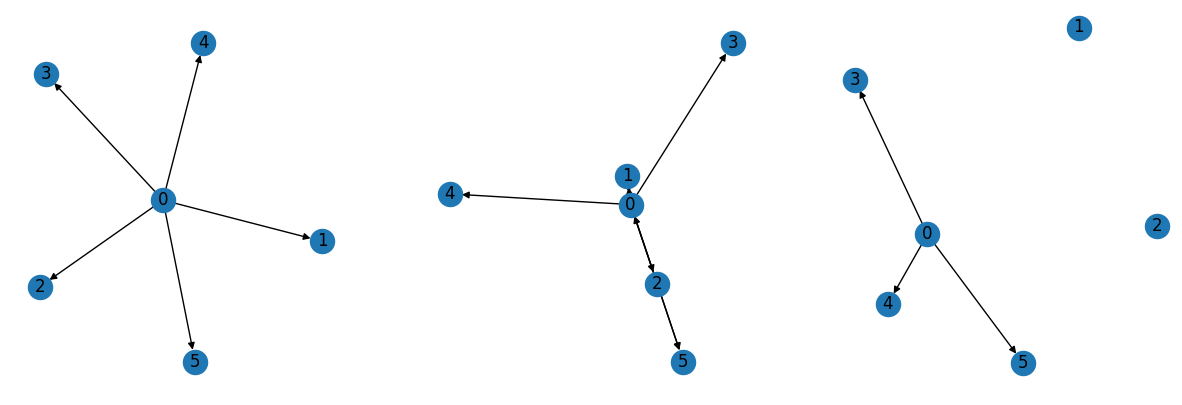

In [81]:
import networkx as nx
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, g_ in enumerate([g, g1, g2]):
    nx.draw(g_.to_networkx(), with_labels=True, ax=axes[i])

### We can also convert a graph to a bidirectional one

In [87]:
g = dgl.to_bidirected(g)

Assigning Node and Edge Features to Graph
-----------------------------------------

Many graph data contain attributes on nodes and edges.
Although the types of node and edge attributes can be arbitrary in real
world, ``DGLGraph`` only accepts attributes stored in tensors (with
numerical contents). Consequently, an attribute of all the nodes or
edges must have the same shape. In the context of deep learning, those
attributes are often called *features*.

You can assign and retrieve node and edge features via ``ndata`` and
``edata`` interface.




In [44]:
# Assign a 3-dimensional node feature vector for each node.
g.ndata['x'] = torch.randn(6, 3)
# Assign a 4-dimensional edge feature vector for each edge.
g.edata['a'] = torch.randn(5, 4)
# Assign a 5x4 node feature matrix for each node.  Node and edge features in DGL can be multi-dimensional.
g.ndata['y'] = torch.randn(6, 5, 4)

print(g.edata['a'])

tensor([[-0.4214, -1.1436, -0.9018,  1.2227],
        [-1.8210,  0.9702, -1.2015,  0.5467],
        [-0.7565, -1.3435,  0.8817,  0.2822],
        [ 0.8598, -0.6573, -1.4167, -2.8816],
        [-0.2668,  0.8970,  0.0106,  1.3062]])


<div class="alert alert-info"><h4>Note</h4><p>The vast development of deep learning has provided us many
   ways to encode various types of attributes into numerical features.
   Here are some general suggestions:

   -  For categorical attributes (e.g. gender, occupation), consider
      converting them to integers or one-hot encoding.
   -  For variable length string contents (e.g. news article, quote),
      consider applying a language model.
   -  For images, consider applying a vision model such as CNNs.

   You can find plenty of materials on how to encode such attributes
   into a tensor in the `PyTorch Deep Learning
   Tutorials <https://pytorch.org/tutorials/>`__.</p></div>




Querying Graph Structures
-------------------------

``DGLGraph`` object provides various methods to query a graph structure.




In [45]:
print(g.num_nodes())
print(g.num_edges())
# Out degrees of the center node
print(g.out_degrees(0))
# In degrees of the center node - note that the graph is directed so the in degree should be 0.
print(g.in_degrees(0))

6
5
5
0


# Message passing

<img src="./messages.jpeg"  width="500" height="665">

### In DGL the `update_all` function can be used to perform all three steps in one go

### First load some ones onto all the nodes

In [88]:
import dgl.function as fn

ones = torch.ones(4)
g.ndata['count'] = dgl.broadcast_nodes(g, ones)
print(g.ndata['count'])

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])


/Users/ets/miniconda3/lib/python3.10/site-packages/dgl/readout.py:443: DGLWarning: For a single graph, use a tensor of shape (1, *) for graph_feat. The support of shape (*) will be deprecated.
  dgl_warning(


### Then for each node, let's add up its neighbors

In [89]:
g.update_all(
    fn.copy_u('count', 'm'), # <-- propagate
    fn.sum('m', 'sum')       # <-- aggregate
    )

### Let's look at the resulting feature

In [90]:
print(g.ndata['sum'])

tensor([[5., 5., 5., 5.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])


### We can define our own custom aggregate function (including an update)

In [91]:
def aggregate(nodes):
    mail = nodes.mailbox['m']
    my_sum = torch.sum(mail,dim=1) / g.num_nodes()
    return {'my sum': my_sum}

In [92]:
g.update_all(
    fn.copy_u('count', 'm'), # <-- propagate
    aggregate                # <-- aggregate
    )

In [96]:
print(g.ndata['my sum'])

tensor([[0.8333, 0.8333, 0.8333, 0.8333],
        [0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667]])
